# Titanic
The Titanic dataset is a classic dataset used for binary classification tasks. The goal is to predict whether a passenger survived the Titanic disaster based on various features such as age, gender, class, and fare.

We start by importing the necessary libraries for data manipulation, visualization, and machine learning.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson, chi2_contingency
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report 
import warnings
warnings.filterwarnings('ignore')

### Loading the Dataset
We load the Titanic dataset from a CSV file and display the first few rows to get an overview of the data.

In [3]:
df = pd.read_csv("Titanic-Dataset.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Data Cleaning

Dropping Unnecessary Columns

In [4]:
df.drop(columns=['PassengerId', 'Name','Ticket'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


Showing how many samples are in the dataset

In [5]:
print(f'sample rows: {df.shape[0]}')

sample rows: 891


Getting to know what kind of data type we have in the dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


- Sex, Cabin and Embarked features are categorical features it's in the dataset
Many Null values are in the Cabin and Age features

We create a heatmap to visualize the missing values in the dataset.

Text(0.5, 1.0, 'Missing Values Heatmap')

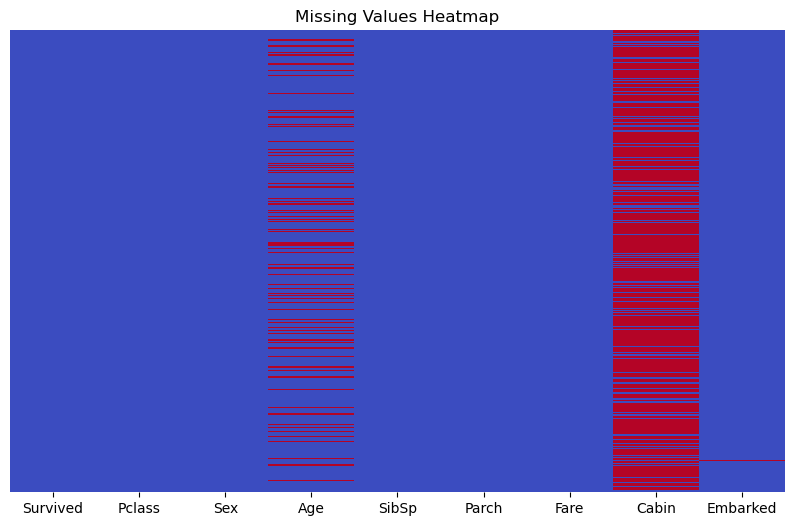

In [7]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cmap='coolwarm', cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")

Calculating the ratio of Null values in each feature

In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False) * 100
missing_values = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_values)

          Total    Percent
Cabin       687  77.104377
Age         177  19.865320
Embarked      2   0.224467
Survived      0   0.000000
Pclass        0   0.000000
Sex           0   0.000000
SibSp         0   0.000000
Parch         0   0.000000
Fare          0   0.000000


- More than 70% of Cabin feature is Null and because of that this feature doesn't have any usage
so, we remove this feature.

In [9]:
df.drop(columns='Cabin', axis=1, inplace=True)
df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C


We check for and remove any duplicate rows in the dataset.

In [10]:
df.duplicated().sum()

111

Showing the duplicated rows

In [11]:
print(df[df.duplicated(keep='first')])

     Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
47          1       3  female   NaN      0      0   7.7500        Q
76          0       3    male   NaN      0      0   7.8958        S
77          0       3    male   NaN      0      0   8.0500        S
87          0       3    male   NaN      0      0   8.0500        S
95          0       3    male   NaN      0      0   8.0500        S
..        ...     ...     ...   ...    ...    ...      ...      ...
870         0       3    male  26.0      0      0   7.8958        S
877         0       3    male  19.0      0      0   7.8958        S
878         0       3    male   NaN      0      0   7.8958        S
884         0       3    male  25.0      0      0   7.0500        S
886         0       2    male  27.0      0      0  13.0000        S

[111 rows x 8 columns]


Removing duplicated rows because don't have any usage

In [12]:
df.drop_duplicates(keep='first', inplace=True)
print(f'Duplicated rows: {df.duplicated().sum()}')

Duplicated rows: 0


### Descriptive Statistics
- We generate descriptive statistics for the numerical columns in the dataset.

In [13]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,780.000000,780.000000,676.000000,780.000000,780.000000,780.000000
mean,0.412821,2.246154,29.812751,0.525641,0.417949,34.829108
std,0.492657,0.854452,14.727098,0.988046,0.838536,52.263440
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,20.000000,0.000000,0.000000,8.050000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,15.950000
75%,1.000000,3.000000,39.000000,1.000000,1.000000,34.375000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


We analyze the distribution of the data, including the count of unique values in categorical columns.

In [14]:
df.describe(include=['object'])

,Sex,Embarked
count,780,778
unique,2,3
top,male,S
freq,488,565


Visulazing the histogram of Age, Fare, Siblings and Passenger Class features

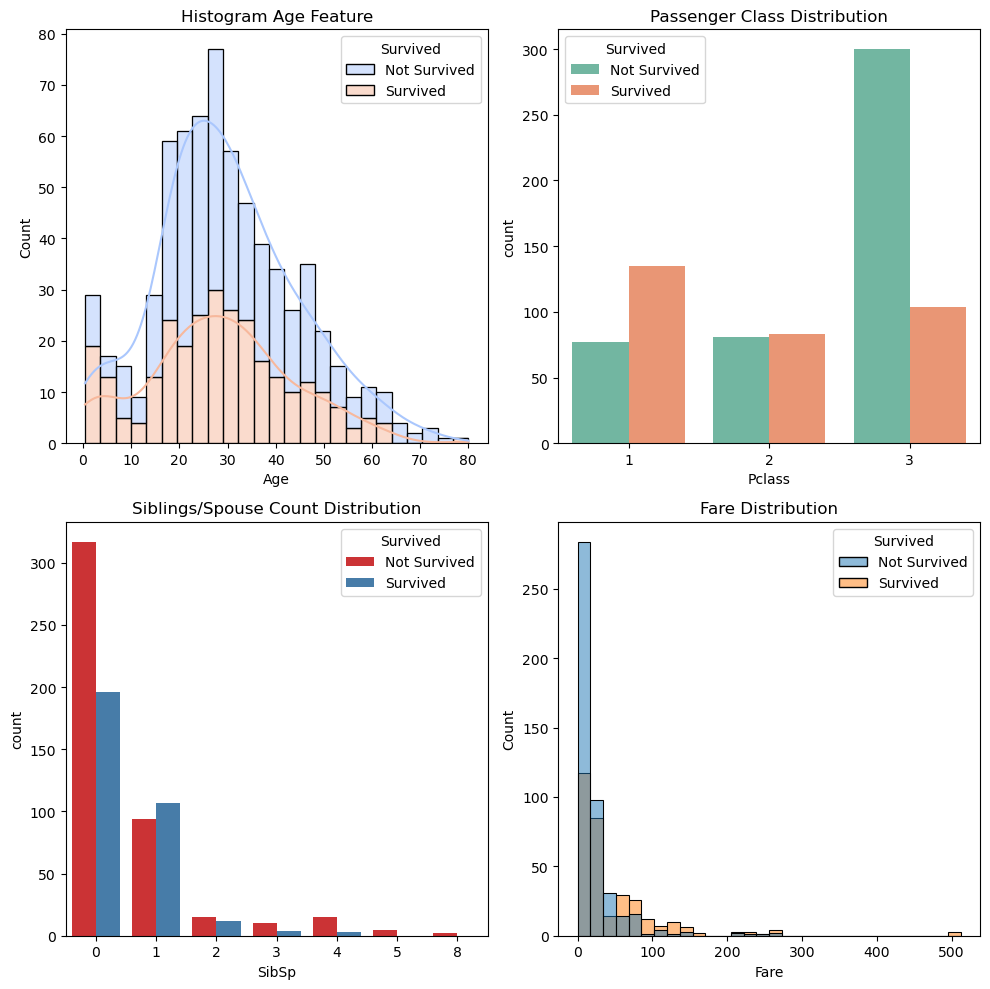

In [15]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

df['Survived'] = df['Survived'].map({0 : "Not Survived", 1 : "Survived"})

sns.histplot(data=df, x='Age',hue='Survived', bins=25, kde=True, ax=ax[0,0], palette='coolwarm', multiple='stack')
ax[0,0].set_title("Histogram Age Feature")

sns.countplot(data = df, x='Pclass',hue='Survived', ax=ax[0,1], palette='Set2')
ax[0,1].set_title("Passenger Class Distribution")

sns.countplot(data=df, x='SibSp', hue='Survived', ax=ax[1,0], palette='Set1')
ax[1,0].set_title("Siblings/Spouse Count Distribution")

sns.histplot(data=df, x='Fare',hue='Survived', ax=ax[1,1], bins=30)
ax[1,1].set_title("Fare Distribution")

plt.tight_layout()
plt.show()


- Most of passengers were 20-30 years old and the histogram of Age feature has a little skewness to the right.
- the class of most passengers were 3 and sound like class 1 has direct relationship with Surviving and a indirect relationship with class 3
- Histogram of Fare feature has very skewness to the right it sound like has outliers and those passengers who have paid more than 50 dollurs survived in compare with passengers who paid less than 50 doluurs

Showing the relationship of Passenger class, Siblings/Spouse,  Sex and Embarkation features with the target column (Survived)

Text(0.5, 1.0, 'Survival Rate by Embarkation Point')

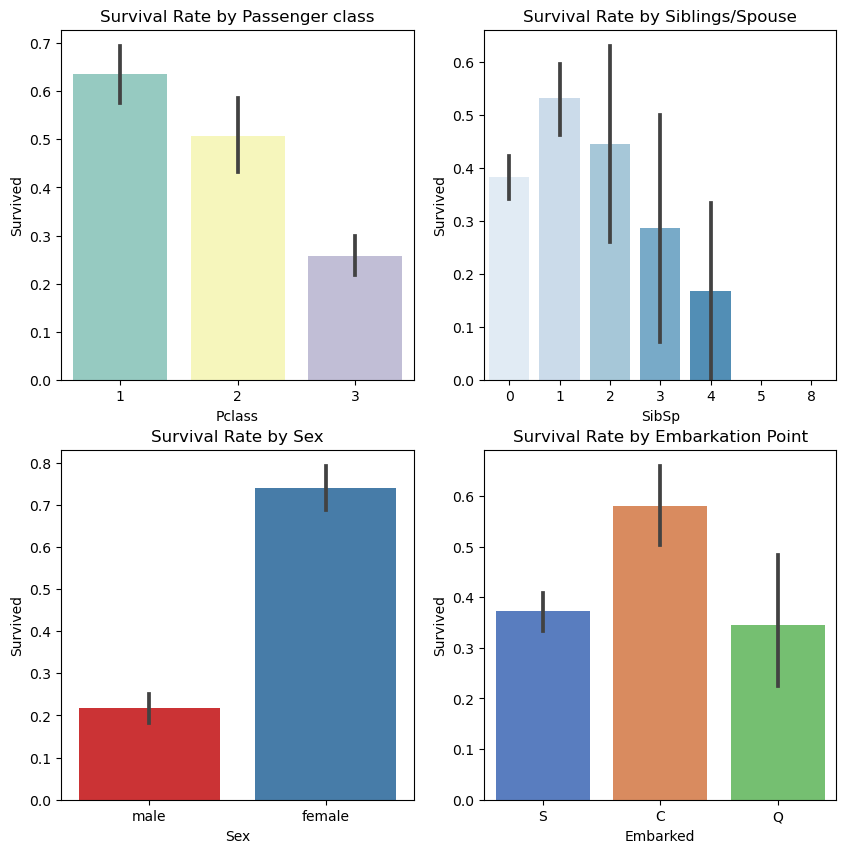

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))

df['Survived'] = df['Survived'].map({"Not Survived" : 0, "Survived" : 1})

sns.barplot(x='Pclass', y='Survived', data=df, ax=ax[0,0], palette='Set3')
ax[0,0].set_title("Survival Rate by Passenger class")

sns.barplot(x='SibSp', y='Survived', data=df, ax=ax[0,1], palette='Blues')
ax[0,1].set_title("Survival Rate by Siblings/Spouse")

sns.barplot(x='Sex', y='Survived', data=df, ax=ax[1,0], palette='Set1')
ax[1,0].set_title("Survival Rate by Sex")

sns.barplot(x='Embarked', y='Survived', data=df, ax=ax[1,1], palette='muted')
ax[1,1].set_title("Survival Rate by Embarkation Point")

- Sex feature shows a steep relationship with target column
- It's look like the class passengers who were lower, they had more chance to survive.
- Embarked

Showing outliers of each numeric column

Checking if categorical features have any relationship with target column with chi2 test

In [17]:
categorical_features = ['Sex', 'Embarked', 'Pclass']

for col in categorical_features:
    contingency_table = pd.crosstab(df[col], df['Survived'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Feature {col}")
    print(f"P-value: {p:.4f}  which is {'less than' if p < 0.05 else 'greater than'} 0.05")
    print('-' * 70)

Feature Sex
P-value: 0.0000  which is less than 0.05
----------------------------------------------------------------------
Feature Embarked
P-value: 0.0000  which is less than 0.05
----------------------------------------------------------------------
Feature Pclass
P-value: 0.0000  which is less than 0.05
----------------------------------------------------------------------


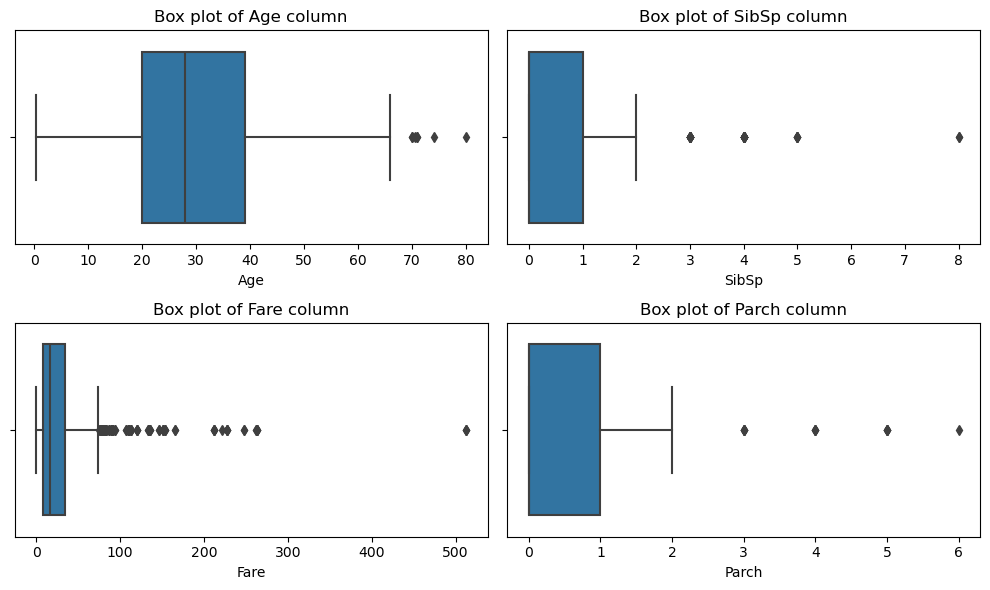

In [18]:
fig, ax = plt.subplots(2, 2,figsize=(10,6))

sns.boxplot(x=df['Age'], ax=ax[0,0])
ax[0,0].set_title('Box plot of Age column')

sns.boxplot(x=df['Fare'], ax=ax[1,0])
ax[1,0].set_title('Box plot of Fare column')

sns.boxplot(x=df['SibSp'], ax=ax[0,1])
ax[0,1].set_title('Box plot of SibSp column')

sns.boxplot(x=df['Parch'], ax=ax[1,1])
ax[1,1].set_title('Box plot of Parch column')

plt.tight_layout()
plt.show()

Calculating what percentage of each numeric column is outlier

In [19]:
num_df = df.select_dtypes(include=['int', 'float'])

def outlier_percentage(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    percentage = len(outliers) / len(df) * 100
    return round(percentage, 2)

In [20]:
for col in num_df.columns:
    print(f"{outlier_percentage(num_df, col)}% of {col} column is outlier.")
    print('-' * 50)

0.0% of Survived column is outlier.
--------------------------------------------------
0.0% of Pclass column is outlier.
--------------------------------------------------
0.9% of Age column is outlier.
--------------------------------------------------
5.0% of SibSp column is outlier.
--------------------------------------------------
1.92% of Parch column is outlier.
--------------------------------------------------
12.44% of Fare column is outlier.
--------------------------------------------------


- outliers have veru mush numbers, we can't just remove them

Removing just one sample which in Fare column causing too skewness

In [21]:
df = df[(df['Fare'] < 300) & (df["Fare"] != 0)]

Calculating the logarithm of Fare column because of skewness

In [22]:
df['fare_log'] = df['Fare'].apply(lambda x: np.log1p(x))
df['fare_sqrt'] = df['Fare'].apply(lambda x: np.sqrt(x))
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,fare_log,fare_sqrt
0,0,3,male,22.0,1,0,7.2500,S,2.110213,2.692582
1,1,1,female,38.0,1,0,71.2833,C,4.280593,8.442944
2,1,3,female,26.0,0,0,7.9250,S,2.188856,2.815138


Visualizing the histogram of logarithm and root of fare column

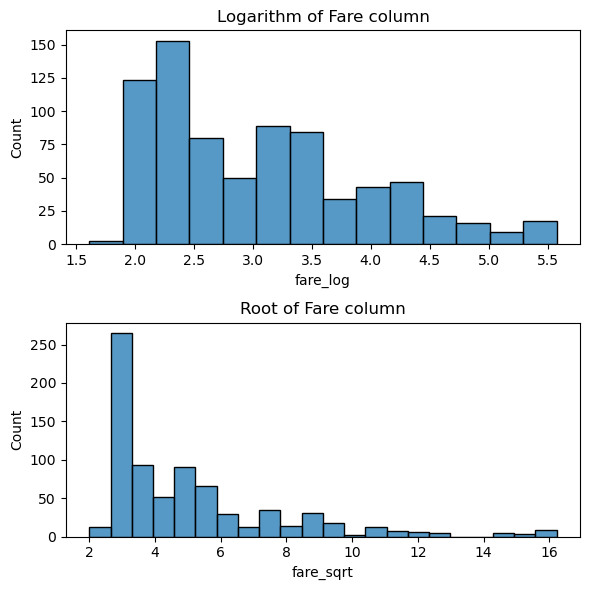

In [23]:
fig, ax = plt.subplots(2, figsize=(6,6))

sns.histplot(x=df['fare_log'], ax=ax[0])
ax[0].set_title('Logarithm of Fare column')

sns.histplot(x=df['fare_sqrt'], ax=ax[1])
ax[1].set_title('Root of Fare column')

plt.tight_layout()
plt.show()

- the logarithm of Fare column is better than root of Fare column soo we choose logarithm of feature.

In [24]:
df.drop(columns=['Fare', 'fare_sqrt'], axis=1, inplace=True)
df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked,fare_log
0,0,3,male,22.0,1,0,S,2.110213
1,1,1,female,38.0,1,0,C,4.280593


we fill the Age column's missing values with replacing values of samples which are near in other features

and for the Embarkation column's missing values with value that has been most repitted in the dataset

In [25]:
df["Embarked"].fillna(df.Embarked.mode()[0], inplace=True)

imputer = KNNImputer(n_neighbors=5)
df["Age"] = imputer.fit_transform(df[["Age"]])

print("Making sure we don't have any missing values: ")
print('-' * 60)
print(df.isnull().sum())

Making sure we don't have any missing values: 
------------------------------------------------------------
Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Embarked    0
fare_log    0
dtype: int64


we saw box plot of Siblings/Spouse and Parents features which have outliers so we sum these two features with each other to lower the impact of outliers

In [26]:
df["Family_size"] = df["SibSp"] + df["Parch"] + 1

df["Alone"] = np.where(df["Family_size"] == 1, 1, 0)

df.drop(columns=['SibSp', 'Parch'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,Embarked,fare_log,Family_size,Alone
0,0,3,male,22.0,S,2.110213,2,0
1,1,1,female,38.0,C,4.280593,2,0
2,1,3,female,26.0,S,2.188856,1,1
3,1,1,female,35.0,S,3.990834,2,0
4,0,3,male,35.0,S,2.202765,1,1


- Sex and Embarkation features have relationship with target column

Encoding categorical features for training model

In [27]:
df_encoded = pd.get_dummies(df, columns=categorical_features,dtype='int')
df_encoded.head()

,Survived,Age,fare_log,Family_size,Alone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,2.110213,2,0,0,1,0,0,1,0,0,1
1,1,38.0,4.280593,2,0,1,0,1,0,0,1,0,0
2,1,26.0,2.188856,1,1,1,0,0,0,1,0,0,1
3,1,35.0,3.990834,2,0,1,0,0,0,1,1,0,0
4,0,35.0,2.202765,1,1,0,1,0,0,1,0,0,1


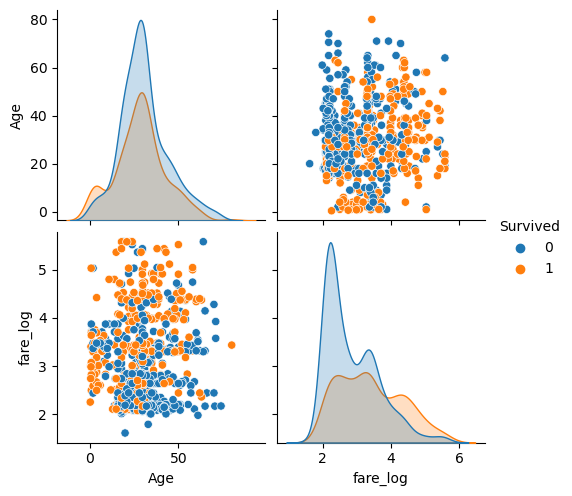

In [28]:
sns.pairplot(data=df_encoded, vars=df_encoded.select_dtypes(include='float'), hue='Survived')
plt.show()

In [29]:
X = df_encoded.iloc[:, 1:]
y = df_encoded.iloc[:, 0]
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression(class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[[75 15]
 [13 51]]


<Axes: >

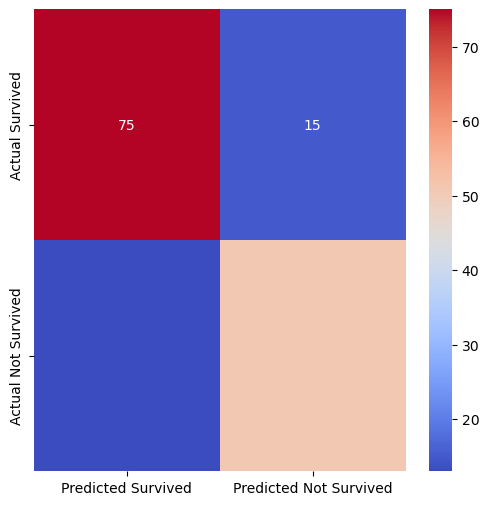

In [31]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.figure(figsize=(6,6))
sns.heatmap(cm,
           annot=True,
           fmt='d',
           cmap='coolwarm',
            xticklabels=['Predicted Survived', 'Predicted Not Survived'],
            yticklabels=['Actual Survived', 'Actual Not Survived']
)

In [32]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        90
           1       0.77      0.80      0.78        64

    accuracy                           0.82       154
   macro avg       0.81      0.82      0.81       154
weighted avg       0.82      0.82      0.82       154



In [33]:
models = {
    'logistic Regression' : LogisticRegression(penalty='l2'),
    'K-Nearest Nieghbors' : KNeighborsClassifier(n_neighbors=3),
    'Random Forest' : RandomForestClassifier(n_estimators=100)
}

for name, model in models.items():
    print('-' * 75)
    print(f"{name}:")

    kf = KFold(6, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)

    print(f"'Average cross validation score: {np.mean(scores):.4f}")

---------------------------------------------------------------------------
logistic Regression:
'Average cross validation score: 0.7721
---------------------------------------------------------------------------
K-Nearest Nieghbors:
'Average cross validation score: 0.7721
---------------------------------------------------------------------------
Random Forest:
'Average cross validation score: 0.7617
